In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import (mutual_info_regression, RFE, SelectFromModel,
                                       SelectKBest, SequentialFeatureSelector, f_regression)
from sklearn.svm import SVR
from sklearn.decomposition import PCA
# VarianceThreshold is for unsupervised problems
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
boston = pd.read_csv('Boston.csv')
boston.drop('Unnamed: 0', axis=1, inplace=True)
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


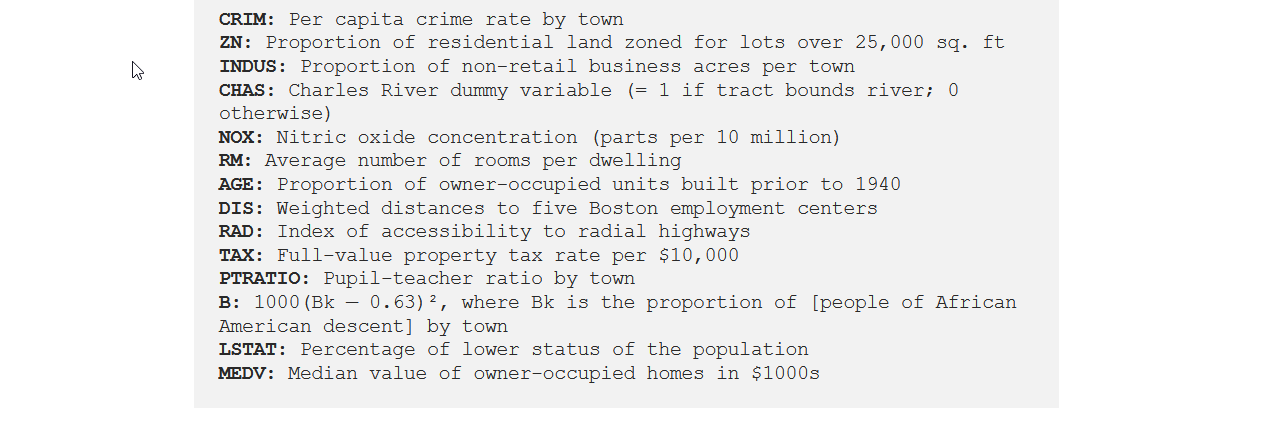

In [3]:
boston.shape

(506, 14)

In [4]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [5]:
boston.isnull().sum().any()

False

## EDA

In [6]:
boston.describe().T

,count,mean,std,min,25%,50%,75%,max
crim,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
zn,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
indus,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
chas,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
nox,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
rm,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
age,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
dis,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
rad,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
tax,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


<Figure size 720x1008 with 0 Axes>

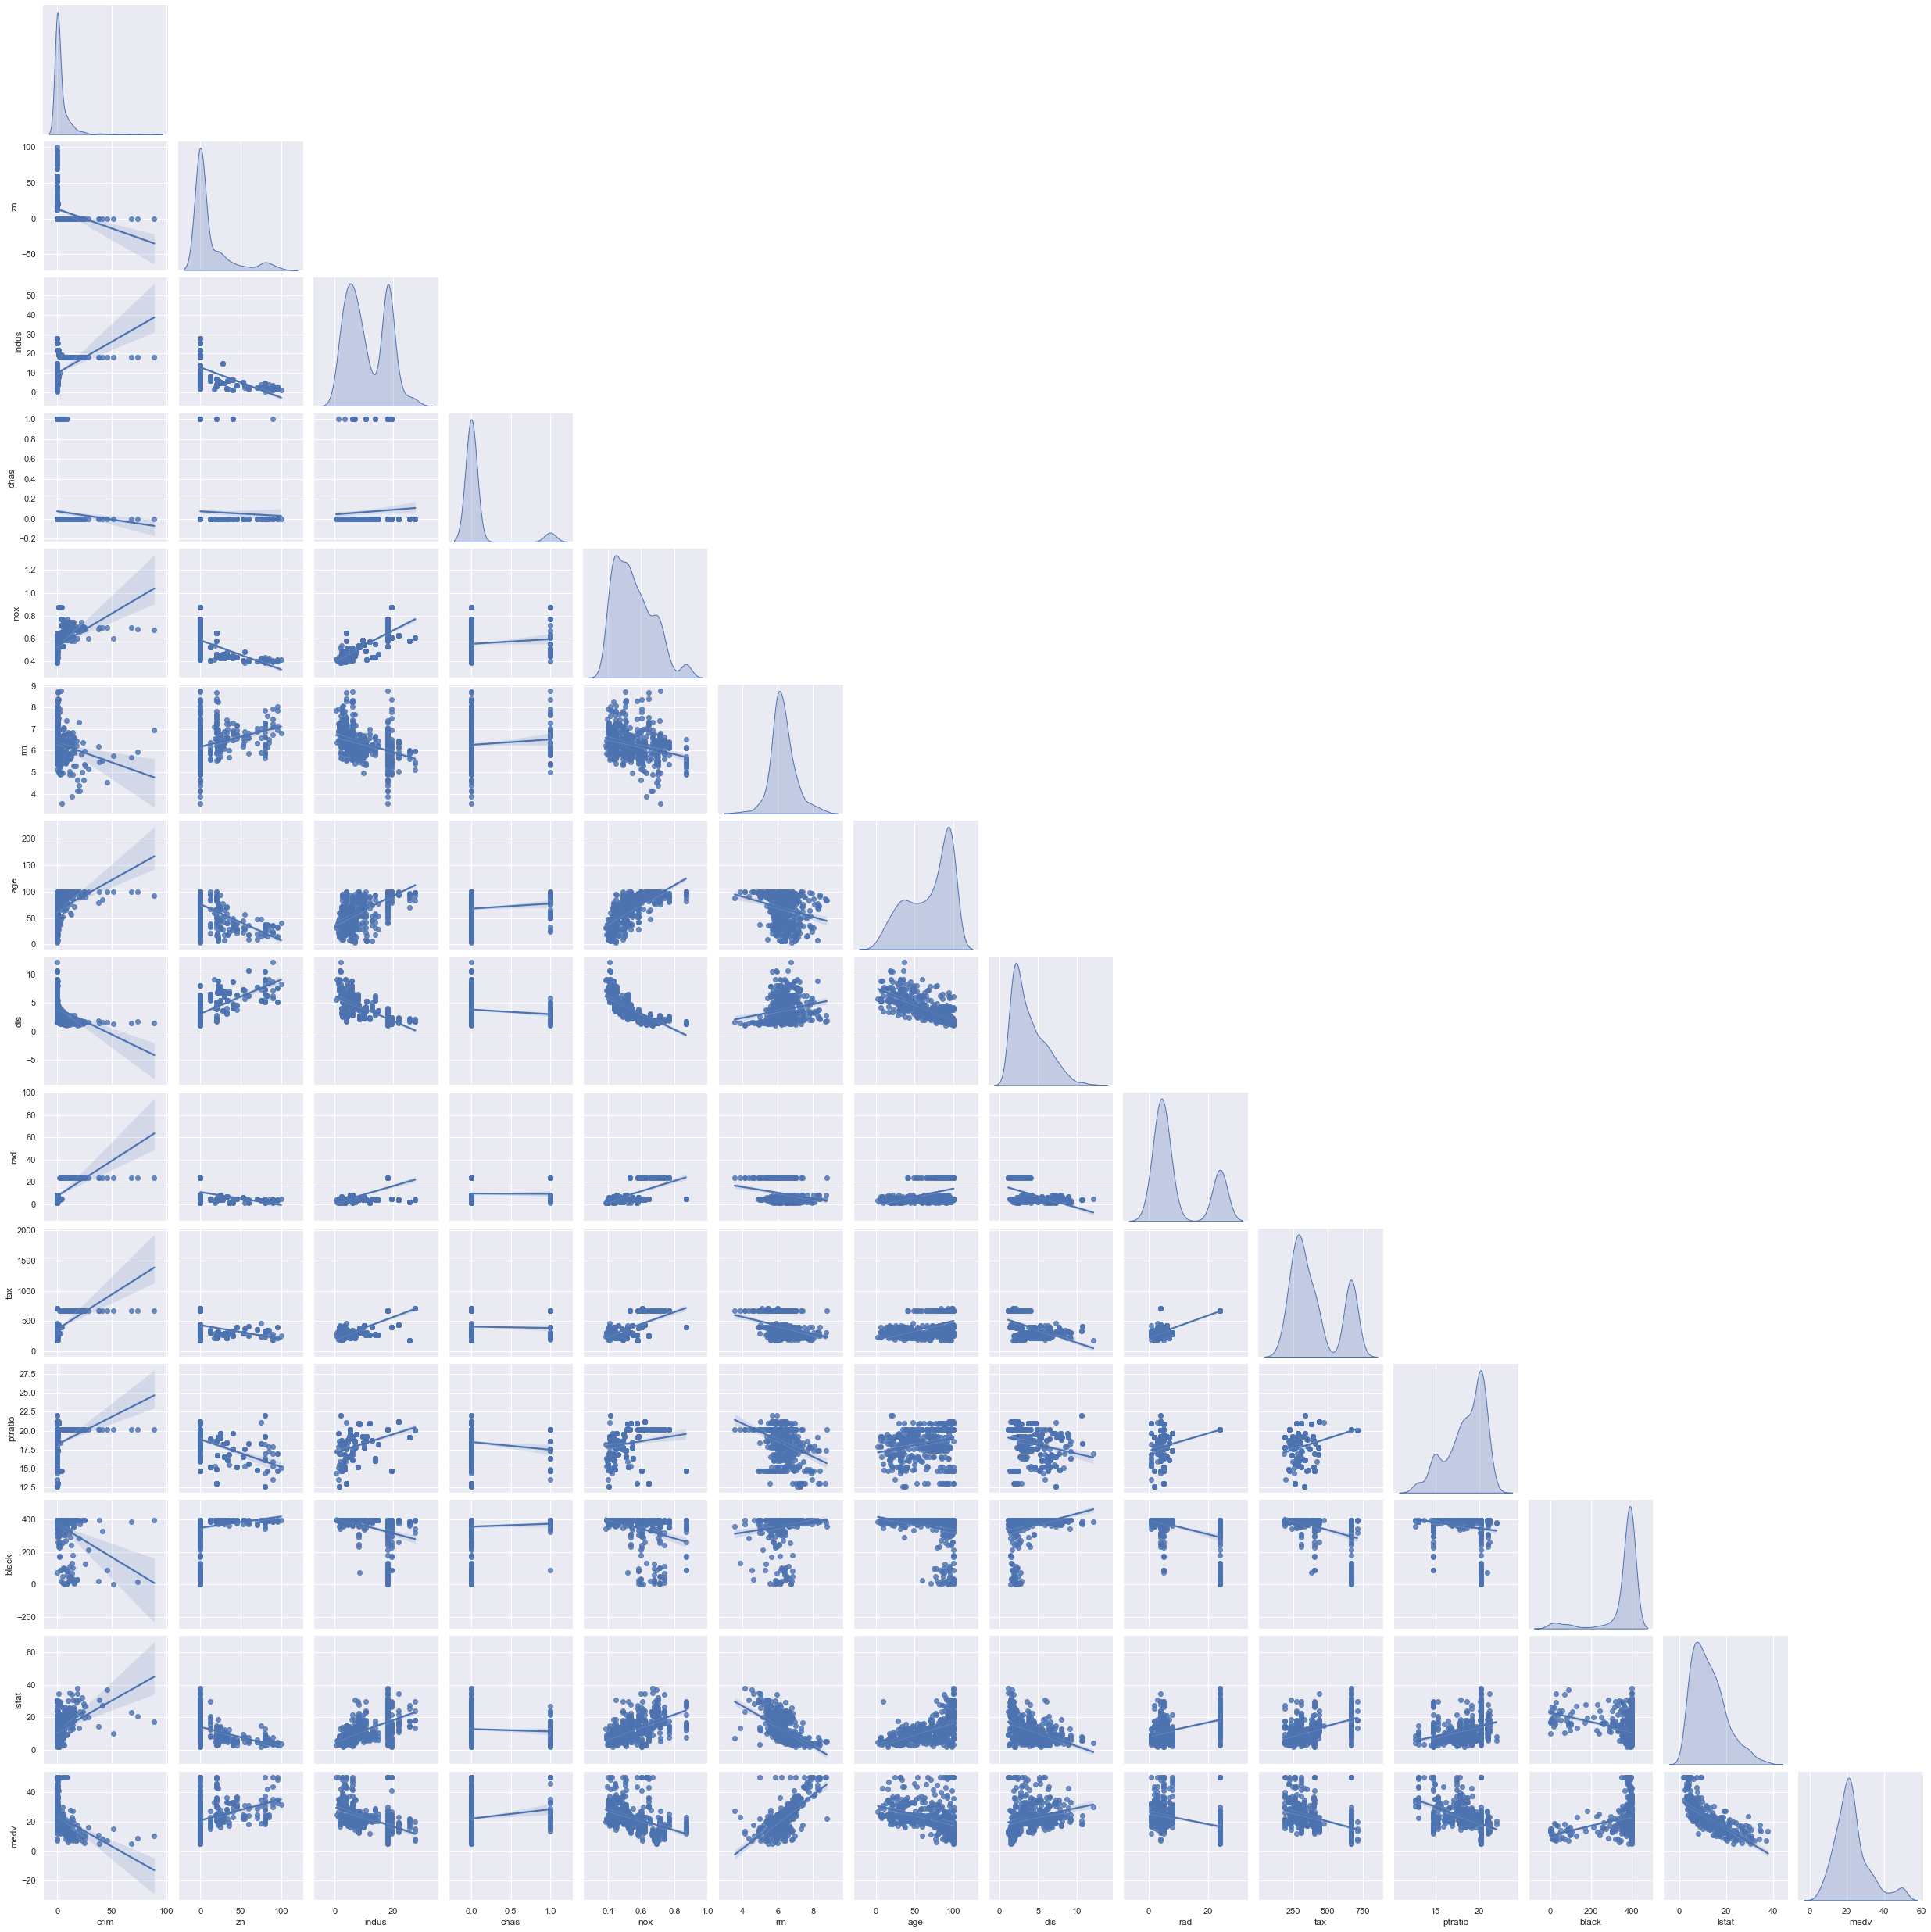

In [7]:
# Let's plot a pairplot
fig = plt.figure(figsize=(10, 14))
p = sns.pairplot(data=boston, diag_kind='kde', kind='reg', corner=True);

## Treating Outliers

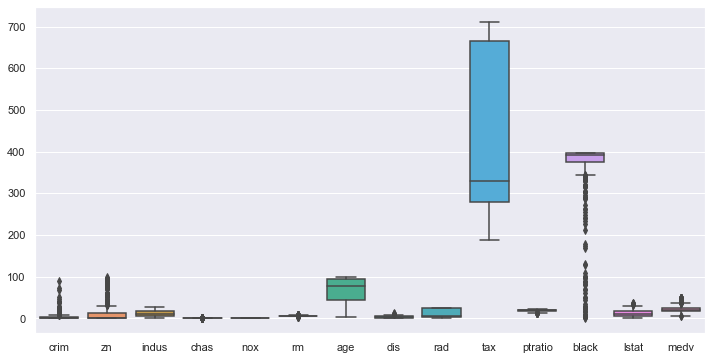

In [8]:
fig = plt.figure(figsize=(12, 6))
sns.boxplot(data=boston);

In [9]:
# remove outliers: separate the samples in the Inter Quantile Range and remove the rest
Q1 = boston.quantile(0.25)
Q3 = boston.quantile(0.75)
IQR = Q3 - Q1
print("IQR:")
print(IQR)
print()
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR
print("Lower limit: ", lower_limit)
print("Upper limit: ", upper_limit)
boston_new = boston[~((boston < lower_limit) | (boston > upper_limit)).any(axis=1)]
print(boston_new.shape)

IQR:
crim         3.595038
zn          12.500000
indus       12.910000
chas         0.000000
nox          0.175000
rm           0.738000
age         49.050000
dis          3.088250
rad         20.000000
tax        387.000000
ptratio      2.800000
black       20.847500
lstat       10.005000
medv         7.975000
dtype: float64

Lower limit:  crim        -5.310511
zn         -18.750000
indus      -14.175000
chas         0.000000
nox          0.186500
rm           4.778500
age        -28.550000
dis         -2.532200
rad        -26.000000
tax       -301.500000
ptratio     13.200000
black      344.106250
lstat       -8.057500
medv         5.062500
dtype: float64
Upper limit:  crim          9.069639
zn           31.250000
indus        37.465000
chas          0.000000
nox           0.886500
rm            7.730500
age         167.650000
dis           9.820800
rad          54.000000
tax        1246.500000
ptratio      24.400000
black       427.496250
lstat        31.962500
medv         36.96250

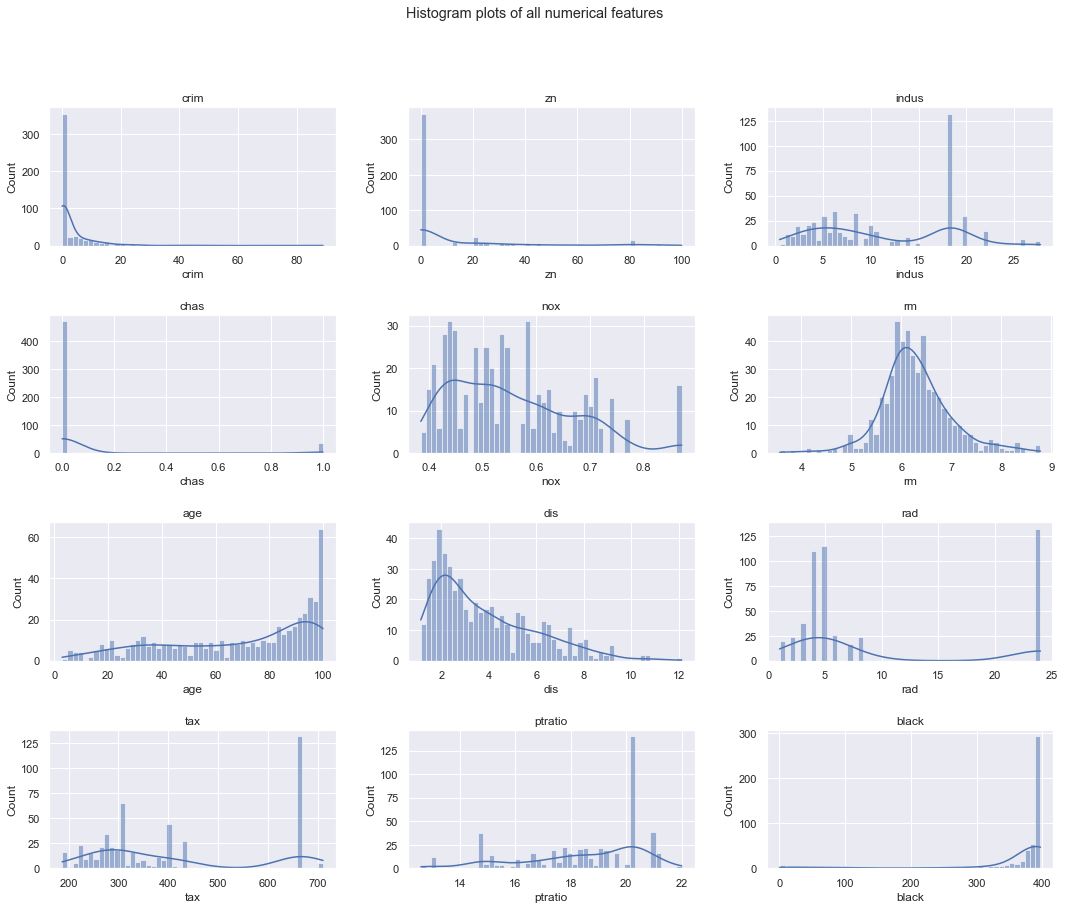

In [10]:
# univariate histogram of fetures
columns = boston.columns.tolist()
fig, ax = plt.subplots(4, 3, figsize=(18, 14))
for ax, col in zip(ax.flat, columns):
    sns.histplot(data=boston, x=col ,bins=50, kde=True, ax=ax)
    ax.set_title(col)
    
# Adjust the subplot layout parameters
fig.subplots_adjust(hspace=0.5, wspace=0.25)
fig.suptitle('Histogram plots of all numerical features');

## Apply scaling fit_transform to the training data and then transform the test data; don't apply fit_transform() to the entire dataset.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    boston.drop('medv', axis=1), boston['medv'], test_size=0.25, random_state=42)

In [12]:
# Normalize and Standardize the features
scaler = make_pipeline(
    StandardScaler(),
    MinMaxScaler()
).fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(type(X_train), type(X_train_scaled))
# boston_scaled = pd.DataFrame(scale_pipe, columns=boston.columns)

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


## Apply LinearRegression to the raw data, without feature selection, and measure score

In [13]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

In [14]:
metrics = [mean_absolute_error, r2_score, mean_squared_error]
for i in metrics:
    print('{0} score for Training: {1} | Testing: {2}'.format(i.__name__, i(y_train, y_train_pred), i(y_test, y_test_pred)))

mean_absolute_error score for Training: 3.366287514452117 | Testing: 3.0609395954370346
r2_score score for Training: 0.748087259862344 | Testing: 0.6844267283527129
mean_squared_error score for Training: 22.34005799215287 | Testing: 22.098694827098


In [15]:
# Plot the prediction
# lin_plot = sns.scatterplot(X_train.values.ravel(), y_train)
# lin_plot = sns.lineplot(X_train.values.ravel(), y_train_pred)
# can't plot multidimensional data

### Polynomial Regression

In [16]:
polyreg=make_pipeline(PolynomialFeatures(degree=3),LinearRegression()).fit(X_train_scaled, y_train)
polyreg_y_train_pred = polyreg.predict(X_train_scaled)

In [17]:
print("Train MAE: ", mean_absolute_error(y_train, polyreg_y_train_pred))
print("Train MSE: ", mean_squared_error(y_train, polyreg_y_train_pred))

Train MAE:  7.358677724628216e-12
Train MSE:  1.0201265094855196e-22


## Feature Selection

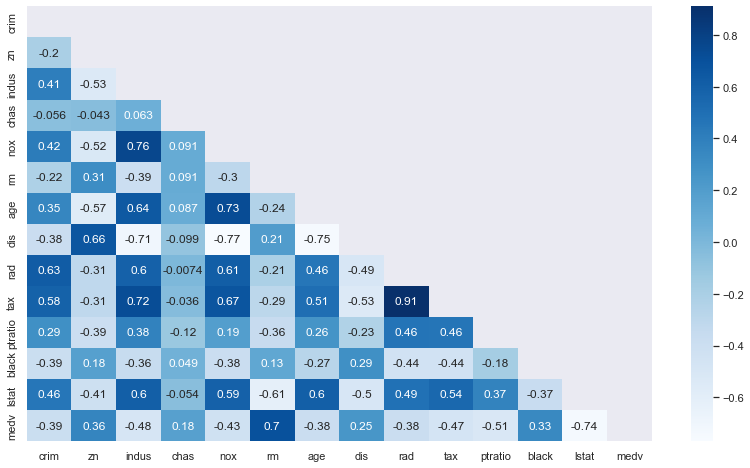

In [18]:
# Let's plot a correlation plot
fig = plt.figure(figsize=(14, 8))
mask = np.triu(np.ones_like(boston.corr(), dtype=bool))
c = sns.heatmap(boston.corr(), cbar=True, annot=True, mask=mask, cmap='Blues');

### Remove highly correlated features

In [19]:
boston_copy = boston.copy()

# Create correlation matrix
corr_matrix = boston_copy.corr().abs()

# Select upper triangle of correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
reduced_matrix = corr_matrix.mask(mask)

# Find features with correlation greater than 0.95
to_drop = [column for column in reduced_matrix.columns if any(reduced_matrix[column] > 0.95)]
print("No. of columns to drop- {0}: {1} ".format(len(to_drop), to_drop))

# Drop features
boston_copy.drop(to_drop, axis=1, inplace=True)

No. of columns to drop- 0: [] 


### Remove multicorrelated features with Variance Inflation Factor (VIF)

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['column_name'] = boston.columns
vif_data['VIF'] = [variance_inflation_factor(boston.values, i) for i in range(boston.shape[1])]
vif_data

,column_name,VIF
0,crim,2.131404
1,zn,2.910004
2,indus,14.485874
3,chas,1.176266
4,nox,74.004269
5,rm,136.101743
6,age,21.398863
7,dis,15.430455
8,rad,15.369980
9,tax,61.939713



    A VIF value of 1 indicates there is no correlation between a given explanatory variable and any other explanatory variables in the model.
    A VIF value between 1 and 5 indicates moderate correlation between a given explanatory variable and other explanatory variables in the model, but this is often not severe enough to require attention.
    A VIF value greater than 5 indicates potentially severe correlation between a given explanatory variable and other explanatory variables in the model. In this case, the coefficient estimates and p-values in the regression output are likely unreliable.


In [21]:
# select columns with VIF > 5
large_VIF_list = list(vif_data[vif_data['VIF'] > 5].column_name)
print("Features to drop: ", len(large_VIF_list))

# drop columns with VIF values accordingly
boston_large_VIF = boston.copy()
boston_large_VIF.drop(large_VIF_list, axis=1, inplace=True)
# boston_large_VIF.head(2)
print("Left over features after applying VIF to remove multicollineared features: ", boston_large_VIF.columns)

Features to drop:  11
Left over features after applying VIF to remove multicollineared features:  Index(['crim', 'zn', 'chas'], dtype='object')


## SelectKBest with mutual_info_regression, f_regression

In [22]:
# need to perform it on the training data
selector = SelectKBest(k=8, score_func=mutual_info_regression)
selector.fit(X_train_scaled, y_train)
mir_train_features = selector.transform(X_train_scaled)

In [23]:
selector.get_support()

array([ True, False,  True, False,  True,  True,  True, False, False,
        True,  True, False,  True])

In [24]:
selector.get_feature_names_out()

array(['x0', 'x2', 'x4', 'x5', 'x6', 'x9', 'x10', 'x12'], dtype=object)

In [25]:
# DataFrame with the features selected by mutual_info_regression on the training set
boston_MIR_df = X_train.iloc[:, selector.get_support()]
boston_MIR_df.head()

,crim,indus,nox,rm,age,tax,ptratio,lstat
182,0.09103,2.46,0.4880,7.155,92.2,193,17.8,4.82
155,3.53501,19.58,0.8710,6.152,82.6,403,14.7,15.02
280,0.03578,3.33,0.4429,7.820,64.5,216,14.9,3.76
126,0.38735,25.65,0.5810,5.613,95.6,188,19.1,27.26
329,0.06724,3.24,0.4600,6.333,17.2,430,16.9,7.34


In [26]:
# need to perform it on the training data
selector = SelectKBest(k=8, score_func=f_regression)
selector.fit(X_train_scaled, y_train)
freg_train_features = selector.transform(X_train_scaled)

In [27]:
selector.get_feature_names_out()

array(['x0', 'x2', 'x4', 'x5', 'x8', 'x9', 'x10', 'x12'], dtype=object)

## SelectFromModel with LinearRegression, RandomForestRegressor

In [28]:
# with LinearRegression
selector = SelectFromModel(estimator=LinearRegression(), max_features=8)
selector.fit(X_train_scaled, y_train)
sfm_lr_train_features = selector.transform(X_train_scaled)

In [29]:
selector.get_feature_names_out()

array(['x0', 'x5', 'x7', 'x10', 'x12'], dtype=object)

In [30]:
# with RandomForestRegressor and unscaled data
selector = SelectFromModel(
    estimator=RandomForestRegressor(n_jobs=-1),
    max_features=8
).fit(X_train, y_train)
sfm_rfr_train_features = selector.transform(X_train)
selector.get_feature_names_out()

array(['rm', 'lstat'], dtype=object)

In [31]:
# with ExtraTreesRegressor
selector = SelectFromModel(
    estimator=ExtraTreesRegressor(n_jobs=-1),
    max_features=8
).fit(X_train, y_train)
sfm_etr_train_features = selector.transform(X_train)
selector.get_feature_names_out()

array(['rm', 'lstat'], dtype=object)

## Recursive Feature Elimination (RFE)

In [32]:
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=8, step=1)
selector.fit(X_train_scaled, y_train)
refe_svr_train_features = selector.transform(X_train_scaled)
# Can also call predict() on the underlying estimator with the reduced features
selector.get_feature_names_out()

array(['x0', 'x4', 'x5', 'x7', 'x9', 'x10', 'x11', 'x12'], dtype=object)

In [33]:
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=8, step=1)
selector.fit(X_train_scaled, y_train)
refe_svr_train_features = selector.transform(X_train_scaled)
selector.get_feature_names_out()

array(['x0', 'x4', 'x5', 'x7', 'x8', 'x10', 'x11', 'x12'], dtype=object)

In [34]:
# with unscaled data
estimator = RandomForestRegressor(n_jobs=-1)
selector = RFE(estimator, n_features_to_select=8, step=1)
selector.fit(X_train, y_train)
refe_svr_train_features = selector.transform(X_train)
selector.get_feature_names_out()

array(['crim', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'lstat'],
      dtype=object)

## Sequential Feature Selection (SFS)

In [35]:
sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=8)
sfs.fit(X_train_scaled, y_train)
sfs_lr_train_features = sfs.transform(X_train_scaled)
sfs.get_feature_names_out()

array(['x0', 'x3', 'x4', 'x5', 'x7', 'x10', 'x11', 'x12'], dtype=object)

In [36]:
sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=8, direction='backward', cv=5)
sfs.fit(X_train_scaled, y_train)
sfs_lr_train_features = sfs.transform(X_train_scaled)
sfs.get_feature_names_out()

array(['x0', 'x3', 'x4', 'x5', 'x7', 'x10', 'x11', 'x12'], dtype=object)

In [37]:
sfs = SequentialFeatureSelector(SVR(), n_features_to_select=8)
sfs.fit(X_train_scaled, y_train)
sfs_lr_train_features = sfs.transform(X_train_scaled)
sfs.get_feature_names_out()

array(['x0', 'x4', 'x5', 'x7', 'x8', 'x9', 'x10', 'x12'], dtype=object)

In [38]:
# with unscaled data
sfs = SequentialFeatureSelector(RandomForestRegressor(n_jobs=-1), n_features_to_select=8)
sfs.fit(X_train, y_train)
sfs_lr_train_features = sfs.transform(X_train)
sfs.get_feature_names_out()

array(['nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'black', 'lstat'],
      dtype=object)

## PCA

In [39]:
components = 8
pca = PCA(n_components=components)
pca.fit(X_train_scaled)
new_components = pca.transform(X_train_scaled)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[0.40613816 0.10358902 0.07427722 0.05127699 0.03676151 0.03276592
 0.02504464 0.01915315]
[0.51584913 0.13157175 0.09434189 0.06512856 0.04669198 0.04161705
 0.03181    0.02432703]


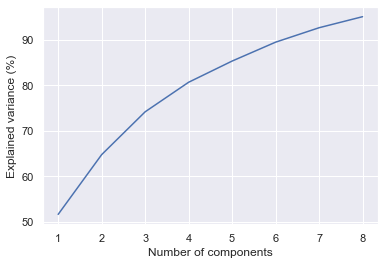

In [40]:
# plot a scree plot
components = len(pca.explained_variance_ratio_) if components is None else components
plt.plot(range(1, components + 1),
        np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)");

In [41]:
print('Top 4 most important features in each component')
print('===============================================')
pca_components = abs(pca.components_)
for row in range(pca_components.shape[0]):
    # get the indices of the top 4 values in each row
    temp = np.argpartition(-(pca_components[row]), 4)
    
    # sort the indices in descending order
    indices = temp[np.argsort((-pca_components[row])[temp])][:4]
    
    # print the top 4 feature names
    print(f'Component {row}: {boston.columns[indices].to_list()}')

Top 4 most important features in each component
Component 0: ['rad', 'tax', 'indus', 'age']
Component 1: ['rad', 'age', 'tax', 'zn']
Component 2: ['chas', 'ptratio', 'rad', 'zn']
Component 3: ['ptratio', 'black', 'chas', 'zn']
Component 4: ['black', 'ptratio', 'chas', 'rad']
Component 5: ['rm', 'lstat', 'zn', 'indus']
Component 6: ['age', 'indus', 'zn', 'lstat']
Component 7: ['indus', 'zn', 'lstat', 'ptratio']


## Histogram plot with scaled data

In [42]:
# scale the dataframe
bostonScaled = make_pipeline(
    StandardScaler(),
    MinMaxScaler()
).fit_transform(boston_new)  # the otliers removed DataFrame

bostonScaledDF = pd.DataFrame(bostonScaled, columns=boston.columns)
bostonScaledDF.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.000000,0.6,0.035281,0.0,0.279221,0.665340,0.641607,0.348369,0.000000,0.206501,0.092308,1.000000,0.073197,0.559567
1,0.002410,0.0,0.215857,0.0,0.129870,0.604059,0.782698,0.459718,0.043478,0.103250,0.476923,1.000000,0.222461,0.472924
2,0.002407,0.0,0.215857,0.0,0.129870,0.908078,0.599382,0.459718,0.043478,0.103250,0.476923,0.921716,0.039110,0.945848
3,0.002991,0.0,0.030349,0.0,0.106061,0.833665,0.441813,0.598743,0.086957,0.065010,0.615385,0.956338,0.000000,0.898917
4,0.007202,0.0,0.030349,0.0,0.106061,0.892957,0.528321,0.598743,0.086957,0.065010,0.615385,1.000000,0.085755,1.000000


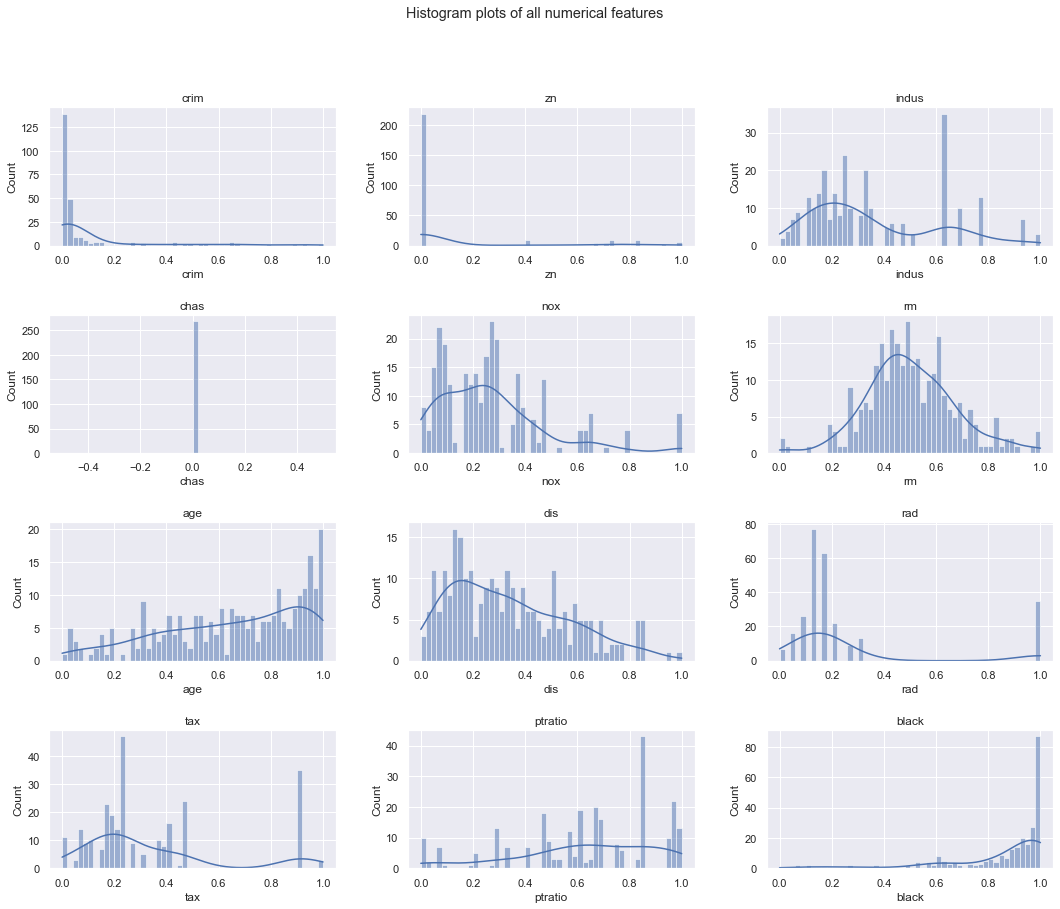

In [43]:
columns = boston.columns.tolist()

# univariate histogram of fetures
fig, ax = plt.subplots(4, 3, figsize=(18, 14))
for ax, col in zip(ax.flat, columns):
    sns.histplot(data=bostonScaledDF, x=col ,bins=50, kde=True, ax=ax)
    ax.set_title(col)
    
# Adjust the subplot layout parameters
fig.subplots_adjust(hspace=0.5, wspace=0.25)
fig.suptitle('Histogram plots of all numerical features');

## Finally, run models for prediction

In [44]:
models = [
    LinearRegression(),
    RandomForestRegressor(),
    ExtraTreesRegressor(),
]

for model in models:
    final_pipe = make_pipeline(
        SelectFromModel(estimator=model, max_features=8),
        model
    ).fit(X_train, y_train)
    y_pred = final_pipe.predict(X_train)
    y_test_pred = final_pipe.predict(X_test)
    
    print("r2 score for training {0}: {1}".format(model, r2_score(y_train, y_pred)))
    print("r2 score for testing {0}: {1}".format(model, r2_score(y_test, y_test_pred)))

r2 score for training LinearRegression(): 0.5703187569869139
r2 score for testing LinearRegression(): 0.48677194091016074
r2 score for training RandomForestRegressor(): 0.9659286106656534
r2 score for testing RandomForestRegressor(): 0.6589201092957232
r2 score for training ExtraTreesRegressor(): 0.9999999468616482
r2 score for testing ExtraTreesRegressor(): 0.6163800415788746


Why are the prediction score so low for LinearRegresion? Why are the histograms of the features the same after scaling and removing outliers?